# Import

Python Library Imports

In [2]:
from copy import deepcopy
from functools import cache
from os import listdir
import json
import pickle
from datetime import datetime

from scipy.special import softmax
import numpy as np
import math
from itertools import combinations

from typing import Any, List, Tuple
import time


# |GPUDrive imports
import torch
import dataclasses
# import mediapy
# from huggingface_hub import PyTorchModelHubMixin
# from huggingface_hub import ModelCardData
# from tqdm import tqdm

Set GPUDrive Root to Working Directory

In [3]:
# |Set root for GPUDrive import
import os
import sys
from pathlib import Path

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive-CoDec':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)
sys.path.append(str(working_dir))

GPUDrive Imports

In [4]:
from gpudrive.utils.config import load_config

Local Imports

In [5]:
from examples.CoDec_Research.code.simulation.construal_main import generate_baseline_data, generate_selected_construal_trajnval
from examples.CoDec_Research.code.gpuDrive_utils import get_gpuDrive_vars
from examples.CoDec_Research.code.analysis.evaluate_construal_actions import evaluate_construals, get_best_construals_likelihood
from examples.CoDec_Research.code.simulation.simulation_functions import simulate_selected_construal_policies
# from simulation.simulation_functions import simulate_construal_policies, simulate_generalist_policies1, simulate_generalist_policies2

RuntimeError: module compiled against ABI version 0x1000009 but this version of numpy is 0x2000000

RuntimeError: module compiled against ABI version 0x1000009 but this version of numpy is 0x2000000

2025-05-01 17:37:02.799244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746135422.867317   89312 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746135422.888745   89312 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746135423.041356   89312 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746135423.041416   89312 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746135423.041417   89312 computation_placer.cc:177] computation placer alr

RuntimeError: module compiled against ABI version 0x1000009 but this version of numpy is 0x2000000

# Set up Environment

Specify Environment Configuration

In [6]:
# |Location to store simulation results
out_dir = "examples/CoDec_Research/results/simulation_results/"

# |Model Config (on which model was trained)
training_config = load_config("examples/experimental/config/reliable_agents_params")

# |Set scenario path
dataset_path = 'data/processed/construal'

# |Set simulator config
max_agents = training_config.max_controlled_agents   # Get total vehicle count
num_parallel_envs = 3
total_envs = 12
device = "cpu" # cpu just because we're in a notebook
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# |Set construal config
construal_size = 1
observed_agents_count = max_agents - 1      # Agents observed except self (used for vector sizes)
sample_size = 1                             # Number of samples to calculate expected utility of a construal

# |Other changes to variables
training_config.max_controlled_agents = 1    # Control only the first vehicle in the environment
total_envs = min(total_envs, len(listdir(dataset_path)))

Instantiate Variables

In [7]:
env_config, train_loader, env, env_multi_agent, sim_agent = get_gpuDrive_vars(
                                                                                training_config = training_config,
                                                                                device = device,
                                                                                num_parallel_envs = num_parallel_envs,
                                                                                dataset_path = dataset_path,
                                                                                max_agents = max_agents,
                                                                                total_envs = total_envs,
                                                                                sim_agent_path= "daphne-cornelisse/policy_S10_000_02_27",
                                                                            )

# Run Evaluation

## Set up parameters

## Generate Baseline Data

Run simulations on the generalist policy and record state information and action distribution for comparison

In [8]:
# |If using saved data
simulation_results_path = "examples/CoDec_Research/results/simulation_results/"
simulation_results_files = [simulation_results_path+fl_name for fl_name in listdir(simulation_results_path)]
for scdFile in simulation_results_files:
    if "baseline_state_action_pairs" not in scdFile:
        continue
    with open(scdFile, 'rb') as opn_file:
        state_action_pairs = pickle.load(opn_file)

Processing Waymo batches:   0%|          | 0/4 [00:00<?, ?it/s]

	sample  0
		Step: 91
	sample  1
		Step: 91
	sample  2
		Step: 91



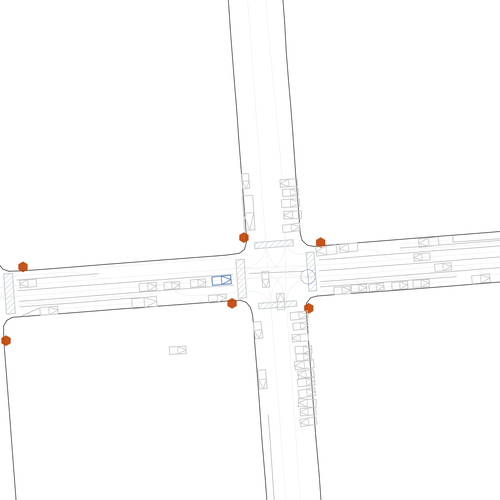
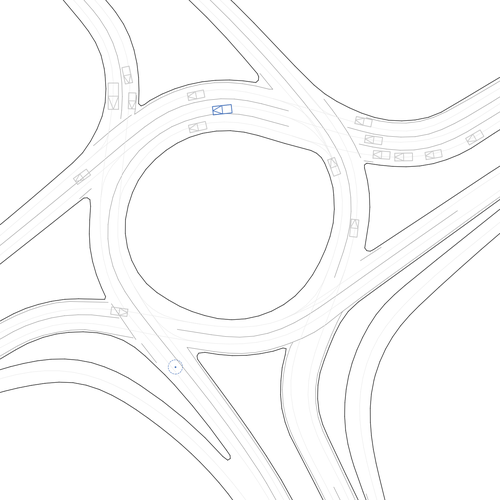
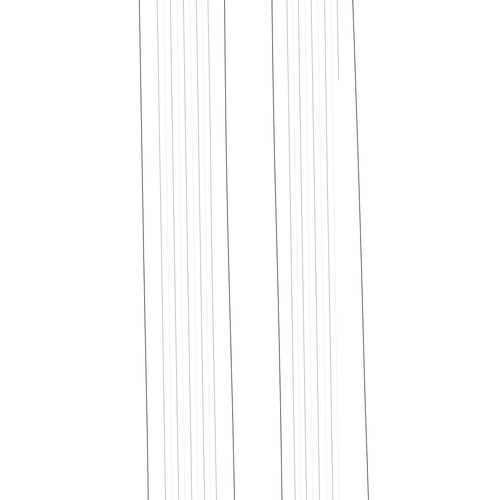
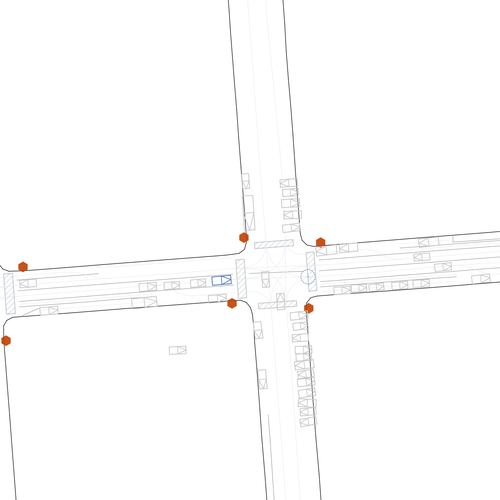
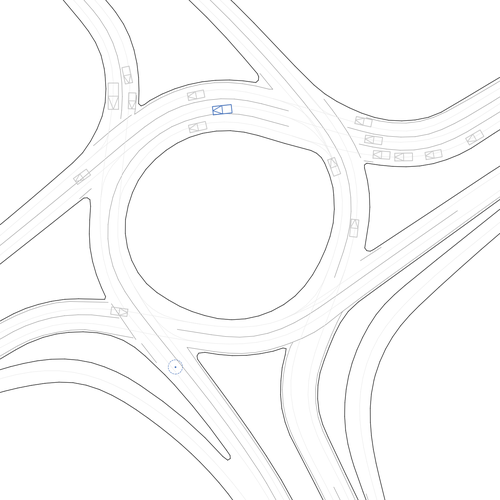
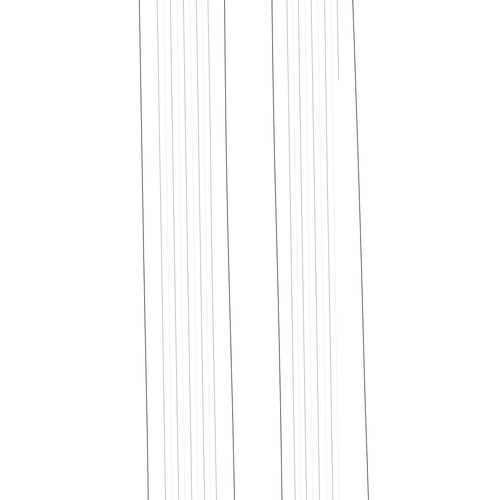
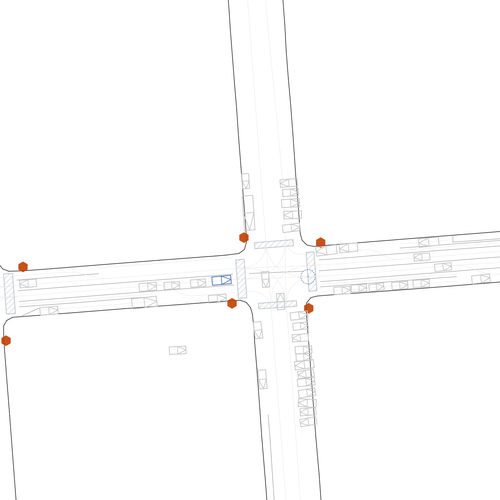
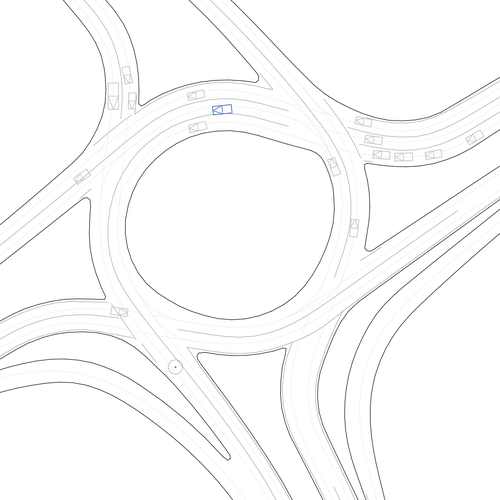
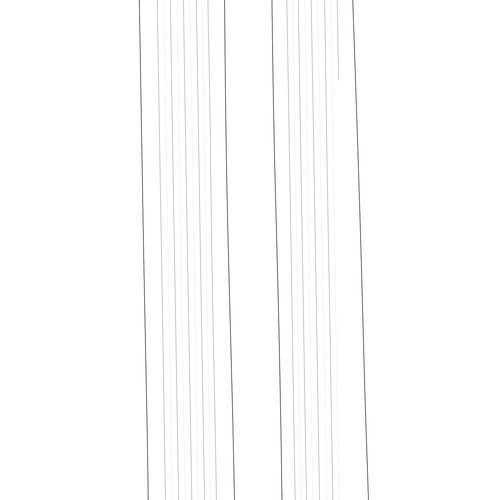

Processing Waymo batches:  25%|██▌       | 1/4 [06:03<18:11, 363.84s/it]

	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90



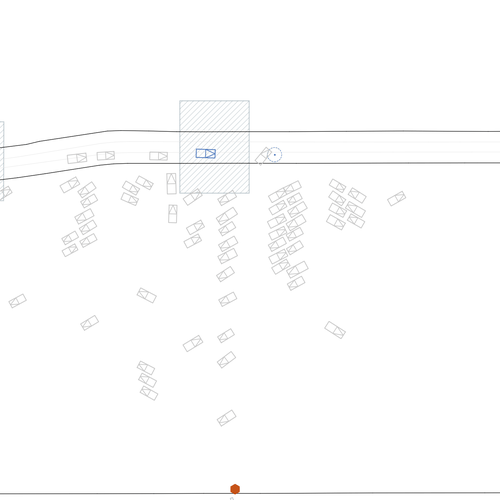
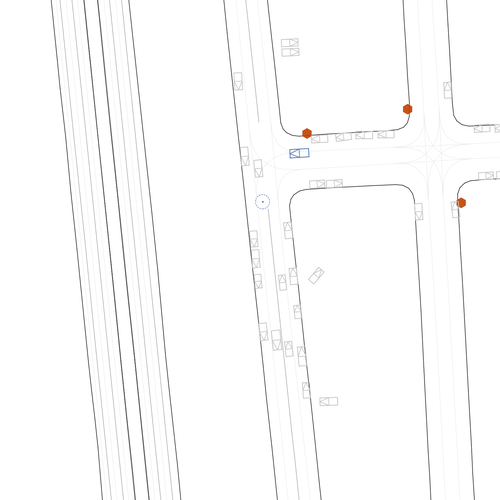
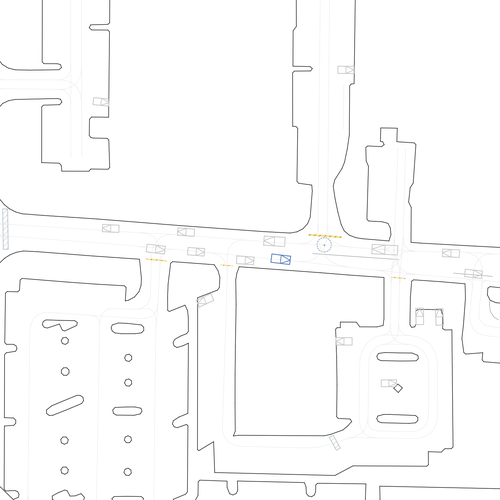
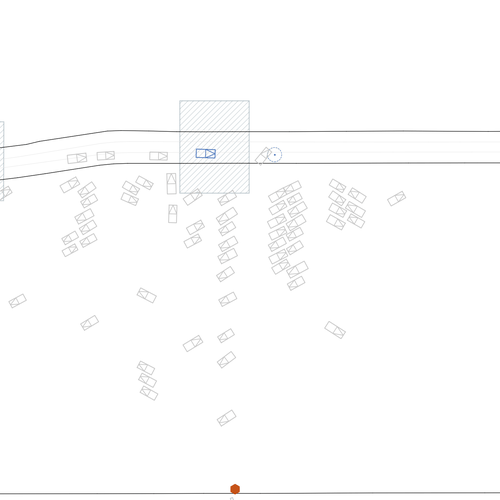
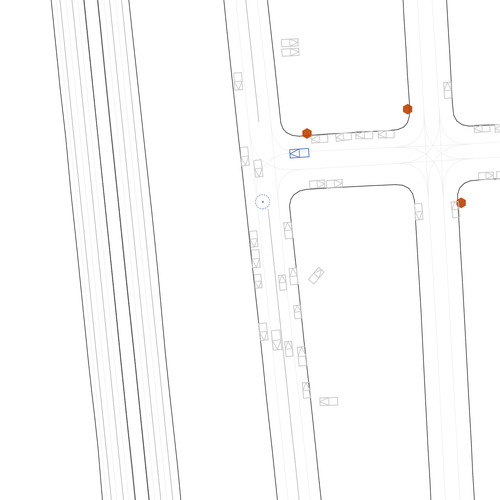
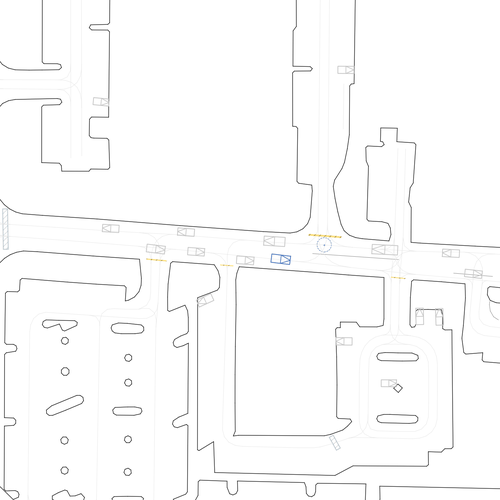
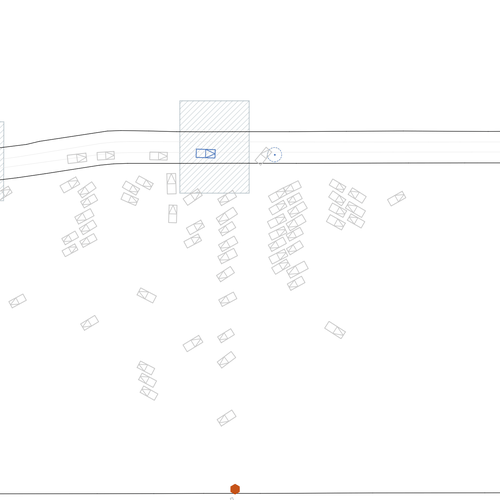
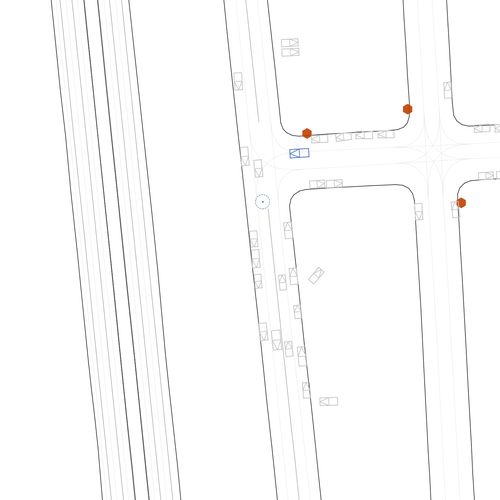
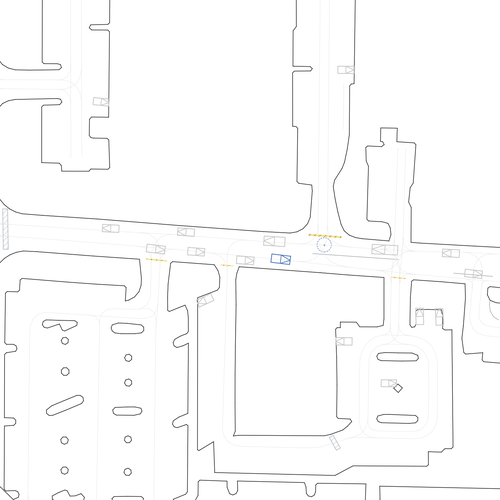

Processing Waymo batches:  50%|█████     | 2/4 [12:10<12:10, 365.45s/it]

	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90



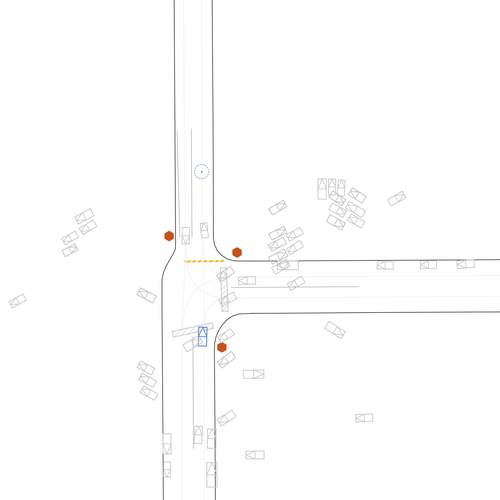
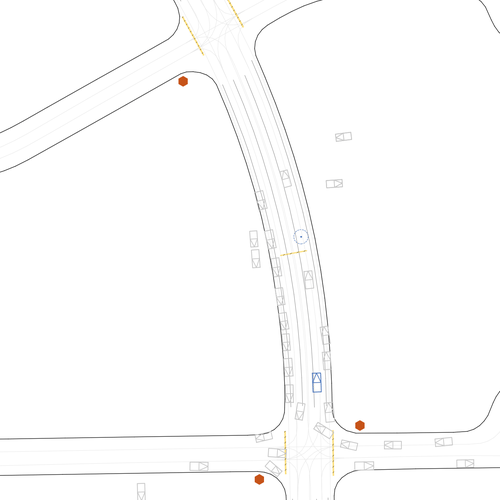
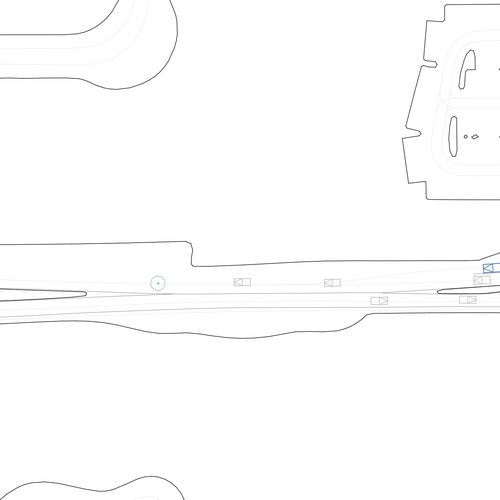
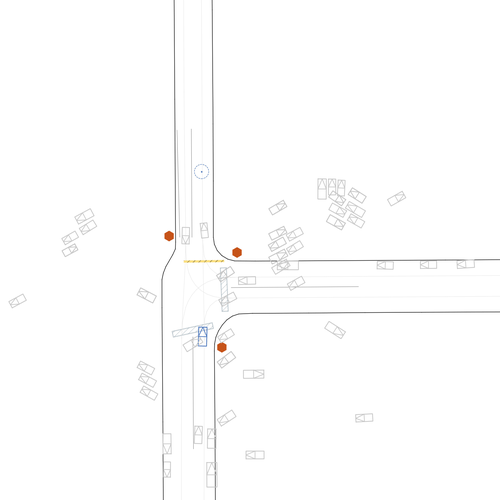
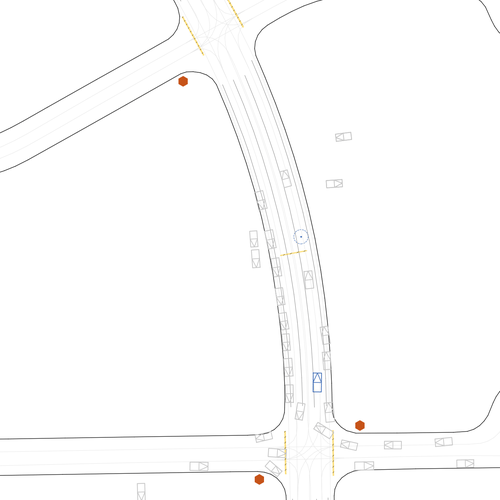
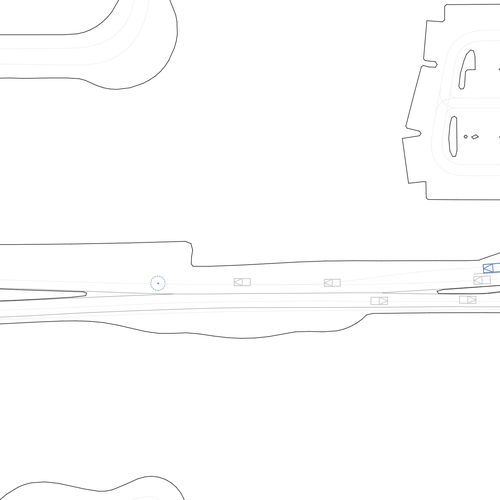
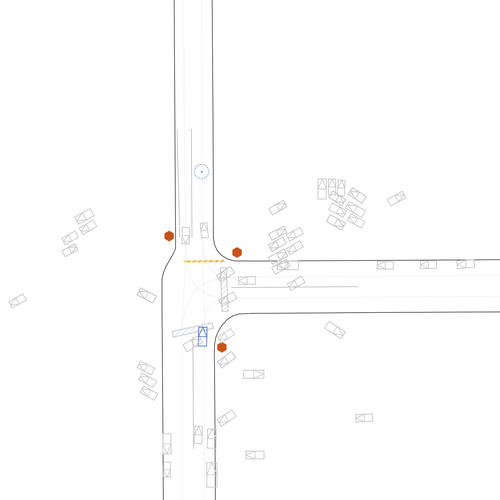
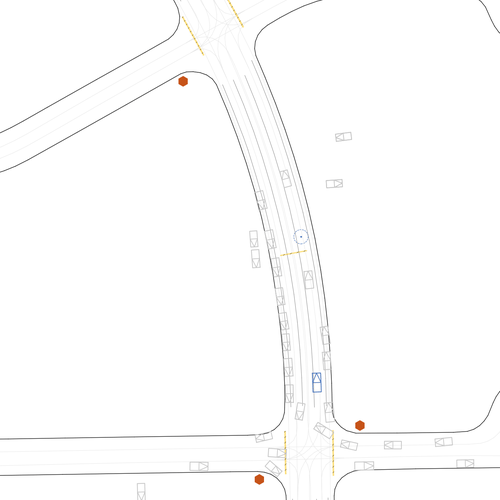
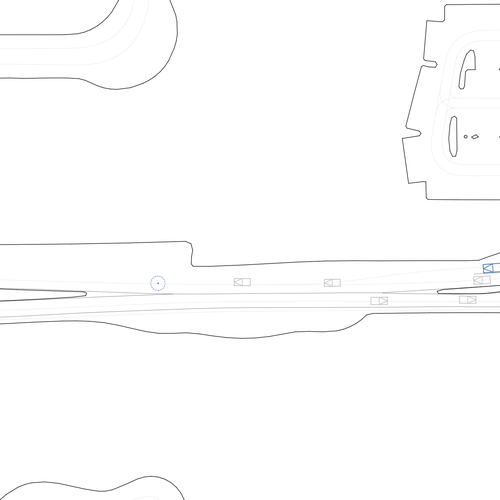

Processing Waymo batches:  75%|███████▌  | 3/4 [19:26<06:37, 397.57s/it]

	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90



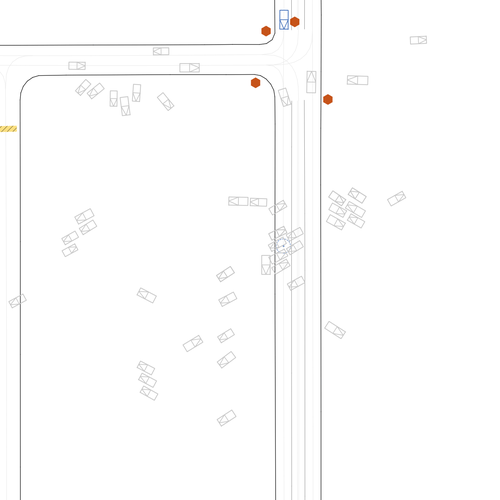
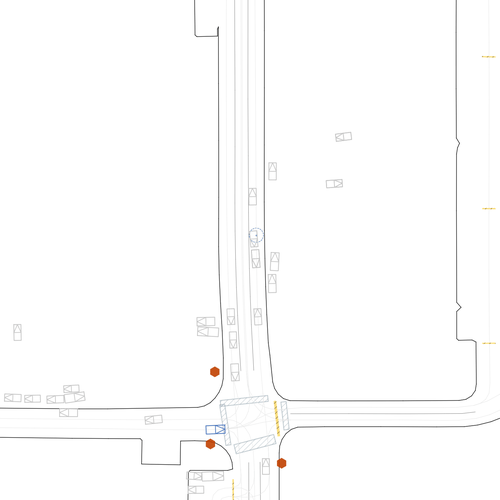
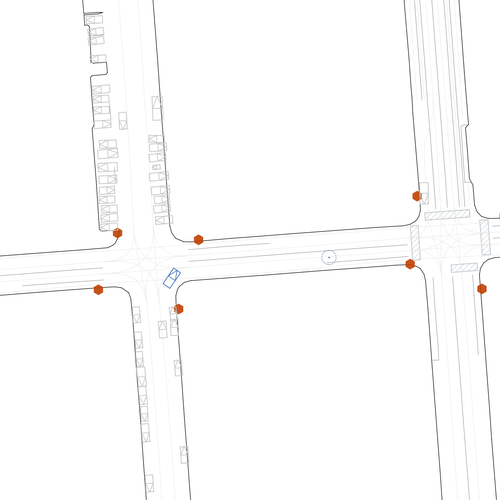
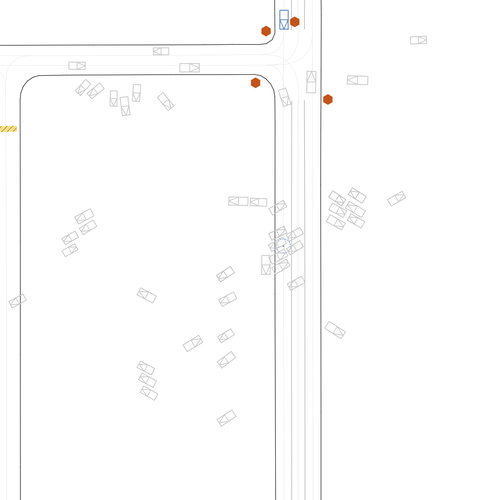
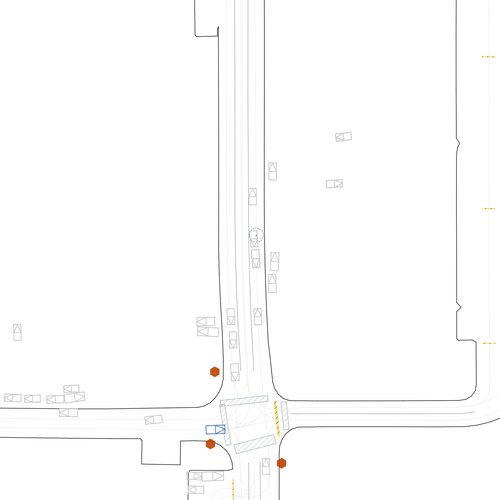
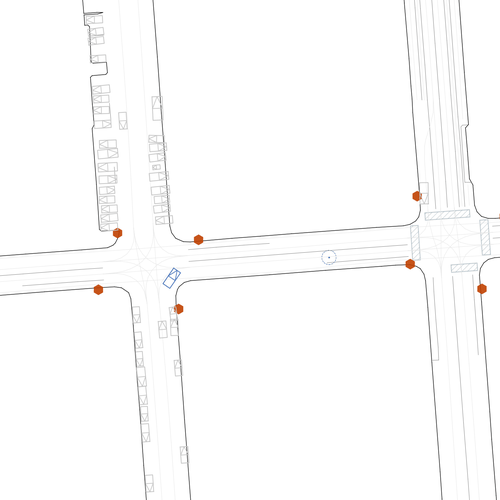
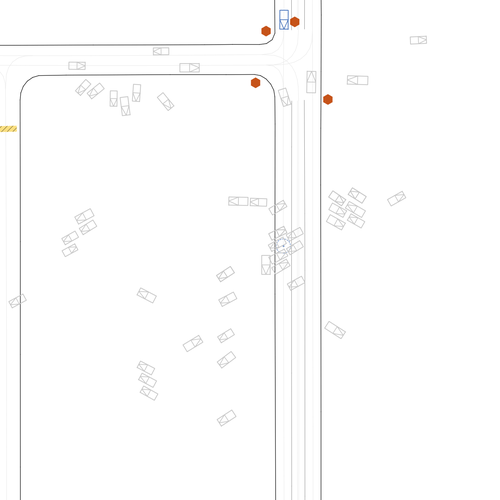
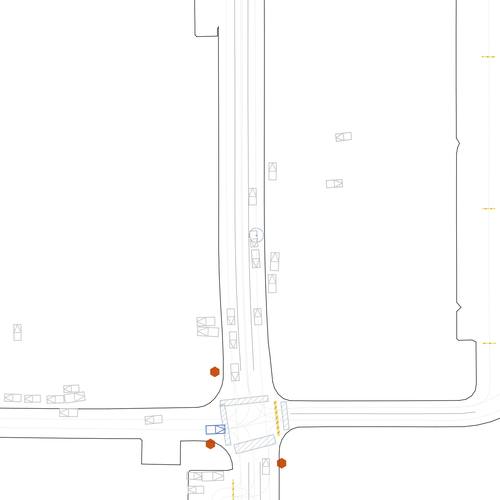
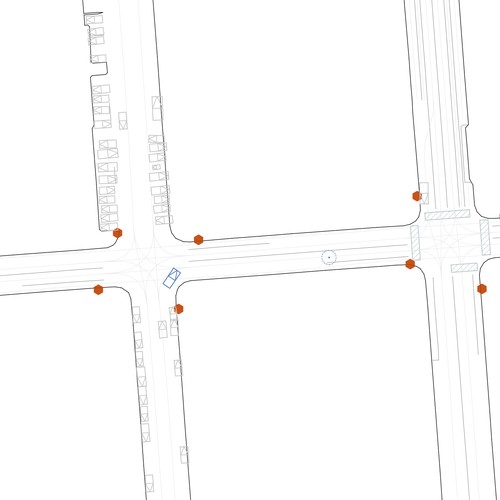

Processing Waymo batches: 100%|██████████| 4/4 [25:13<00:00, 378.37s/it]


Baseline data saved to:  examples/CoDec_Research/results/simulation_results/baseline_state_action_pairs_2025-04-29 20:48:53.310450.pickle


In [7]:
# |OR Generate fresh data
state_action_pairs = generate_baseline_data(out_dir=out_dir,
                                            sim_agent=sim_agent,
                                            num_parallel_envs=num_parallel_envs,
                                            max_agents=max_agents,
                                            sample_size=3,
                                            device=device,
                                            train_loader=train_loader,
                                            env=env,
                                            env_multi_agent=env_multi_agent,
                                            generate_animations=True)

## Get Construal Values

Get log-likelihood values for all construals under the baseline policy

In [8]:
# |If using saved data
simulation_results_path = "examples/CoDec_Research/results/simulation_results/"
simulation_results_files = [simulation_results_path+fl_name for fl_name in listdir(simulation_results_path)]
for scdFile in simulation_results_files:
    if "log_likelihood_measures" not in scdFile:
        continue
    with open(scdFile, 'rb') as opn_file:
        construal_action_likelihoods = pickle.load(opn_file)

In [ ]:
# |OR Generate fresh data
construal_action_likelihoods = evaluate_construals(state_action_pairs, construal_size, sim_agent, out_dir, device=device)

Processing Scene:  data/processed/construal/tfrecord-00101-of-01000_71.json
Processing Construal:  (0,)
Processing Sample:  0
Processing Sample:  1
Processing Sample:  2
Processing Construal:  (1,)
Processing Sample:  0
Processing Sample:  1
Processing Sample:  2
Processing Construal:  (5,)
Processing Sample:  0
Processing Sample:  1
Processing Sample:  2
Processing Construal:  (9,)
Processing Sample:  0
Processing Sample:  1
Processing Sample:  2
Processing Construal:  (10,)
Processing Sample:  0
Processing Sample:  1
Processing Sample:  2
Processing Construal:  (42,)
Processing Sample:  0
Processing Sample:  1
Processing Sample:  2
Processing Construal:  (43,)
Processing Sample:  0
Processing Sample:  1
Processing Sample:  2
Processing Construal:  ()
Processing Sample:  0
Processing Sample:  1
Processing Sample:  2
Processing Scene:  data/processed/construal/tfrecord-00117-of-01000_240.json
Processing Construal:  (0,)
Processing Sample:  0
Processing Sample:  1
Processing Sample:  2


Select Construals based on log likelihood to baseline model (averaged across multiple samples, when available)

In [7]:
# |If using saved data
simulation_results_path = "examples/CoDec_Research/results/simulation_results/"
simulation_results_files = [simulation_results_path+fl_name for fl_name in listdir(simulation_results_path)]
for scdFile in simulation_results_files:
    if "highest_construal_dict_log_likelihood_diff" in scdFile:
        with open(scdFile, 'rb') as opn_file:
            scene_constr_diff_dict = pickle.load(opn_file)
    elif "highest_construal_dict_log_likelihood" in scdFile:
        with open(scdFile, 'rb') as opn_file:
            scene_constr_dict = pickle.load(opn_file)
    else:
        continue       

In [9]:
# |OR Generate fresh data
scene_constr_dict = get_best_construals_likelihood(construal_action_likelihoods, out_dir)
scene_constr_diff_dict = get_best_construals_likelihood(construal_action_likelihoods, out_dir, likelihood_key="log_likelihood_diff")

Highest scene construals dict saved to:  examples/CoDec_Research/results/simulation_results/highest_construal_dict_log_likelihood_2025-04-29 21:14:00.469835.pickle
Highest scene construals dict saved to:  examples/CoDec_Research/results/simulation_results/highest_construal_dict_log_likelihood_diff_2025-04-29 21:14:00.472221.pickle


In [10]:
scene_constr_dict

{'data/processed/construal/tfrecord-00101-of-01000_71.json': [((1,),
   93.86730448404948),
  ((), 89.82473246256511)],
 'data/processed/construal/tfrecord-00117-of-01000_240.json': [((2,),
   285.61017354329425),
  ((), 213.32928975423178)],
 'data/processed/construal/tfrecord-00143-of-01000_179.json': [((4,),
   194.04393259684244),
  ((), 168.57758331298828)],
 'data/processed/construal/tfrecord-00144-of-01000_130.json': [((7,),
   99.49221801757812),
  ((), 99.49221801757812)],
 'data/processed/construal/tfrecord-00183-of-01000_301.json': [((18,),
   138.3513501485189),
  ((), 138.3513501485189)],
 'data/processed/construal/tfrecord-00263-of-01000_345.json': [((5,),
   129.8991470336914),
  ((), 70.4103151957194)],
 'data/processed/construal/tfrecord-00268-of-01000_436.json': [((9,),
   242.4330291748047),
  ((), 241.17550404866537)],
 'data/processed/construal/tfrecord-00308-of-01000_303.json': [((4,),
   208.32998911539713),
  ((), 205.34229024251303)],
 'data/processed/construal

In [8]:
scene_constr_diff_dict

{'data/processed/construal/tfrecord-00101-of-01000_71.json': [((9,),
   -25.024412155151367),
  ((), -1.555683108260079e-05)],
 'data/processed/construal/tfrecord-00117-of-01000_240.json': [((8,),
   -162.53143310546875),
  ((), 4.6888803050630185e-06)],
 'data/processed/construal/tfrecord-00143-of-01000_179.json': [((0,),
   -125.50552876790364),
  ((), 1.559652101453442e-05)],
 'data/processed/construal/tfrecord-00144-of-01000_130.json': [((0,),
   -0.5722983529170355),
  ((), -1.9292046999908052e-05)],
 'data/processed/construal/tfrecord-00183-of-01000_301.json': [((0,),
   -0.5998246769110361),
  ((), 1.8675715788655605e-06)],
 'data/processed/construal/tfrecord-00263-of-01000_345.json': [((8,),
   -128.81005859375),
  ((), 2.1854183766360316e-07)],
 'data/processed/construal/tfrecord-00268-of-01000_436.json': [((0,),
   -2.428205410639445),
  ((), 3.6040930960249774e-05)],
 'data/processed/construal/tfrecord-00308-of-01000_303.json': [((17,),
   -10.090030193328857),
  ((), -1.974

## Evaluate Construals

Generate trajectories for selected construals

In [8]:
# Reload environment
env_config, train_loader, env, env_multi_agent, sim_agent = get_gpuDrive_vars(
                                                                                training_config = training_config,
                                                                                device = device,
                                                                                num_parallel_envs = num_parallel_envs,
                                                                                dataset_path = dataset_path,
                                                                                max_agents = max_agents,
                                                                                total_envs = total_envs,
                                                                                sim_agent_path= "daphne-cornelisse/policy_S10_000_02_27",
                                                                            )

generate_selected_construal_trajnval(out_dir=out_dir,
                                    sim_agent=sim_agent,
                                    observed_agents_count=observed_agents_count,
                                    construal_size=construal_size,
                                    num_parallel_envs=num_parallel_envs,
                                    max_agents=max_agents,
                                    sample_size=sample_size,
                                    device=device,
                                    train_loader=train_loader,
                                    env=env,
                                    env_multi_agent=env_multi_agent,
                                    selected_construals = scene_constr_dict,
                                    generate_animations=True,)

Processing Waymo batches:   0%|          | 0/4 [00:00<?, ?it/s]

Construals per scene:  2
Processing construals:  [(1,), (2,), (4,)]
	sample  0
		Step: 91
Saving animations to:  ./sim_vids
Processing construals:  [(), (), ()]
	sample  0
		Step: 91

Processing Waymo batches:  25%|██▌       | 1/4 [03:54<11:43, 234.50s/it]


Construals per scene:  2
Processing construals:  [(7,), (18,), (5,)]
	sample  0
		Step: 90
Saving animations to:  ./sim_vids
Processing construals:  [(), (), ()]
	sample  0
		Step: 90

Processing Waymo batches:  50%|█████     | 2/4 [07:45<07:44, 232.20s/it]


Construals per scene:  2
Processing construals:  [(9,), (4,), (2,)]
	sample  0
		Step: 90
Saving animations to:  ./sim_vids
Processing construals:  [(), (), ()]
	sample  0
		Step: 90

Processing Waymo batches:  75%|███████▌  | 3/4 [11:58<04:01, 241.98s/it]


Construals per scene:  2
Processing construals:  [(6,), (6,), (23,)]
	sample  0
		Step: 90
Saving animations to:  ./sim_vids
Processing construals:  [(), (), ()]
	sample  0
		Step: 90

Processing Waymo batches: 100%|██████████| 4/4 [15:21<00:00, 230.31s/it]

# Result Samples

Sample 1

In [11]:
scene_constr_dict

{'data/processed/construal/tfrecord-00101-of-01000_71.json': [((1,),
   80.04010772705078),
  ((), 77.61746215820312)],
 'data/processed/construal/tfrecord-00117-of-01000_240.json': [((2,),
   178.8475799560547),
  ((), 167.77102661132812)],
 'data/processed/construal/tfrecord-00143-of-01000_179.json': [((1,),
   164.78912353515625),
  ((), 172.42434692382812)],
 'data/processed/construal/tfrecord-00144-of-01000_130.json': [((7,),
   107.16194152832031),
  ((), 107.16194152832031)],
 'data/processed/construal/tfrecord-00183-of-01000_301.json': [((18,),
   120.21046447753906),
  ((), 120.21046447753906)],
 'data/processed/construal/tfrecord-00263-of-01000_345.json': [((3,),
   73.45822143554688),
  ((), 54.42194366455078)],
 'data/processed/construal/tfrecord-00268-of-01000_436.json': [((5,),
   130.2303009033203),
  ((), 129.53872680664062)],
 'data/processed/construal/tfrecord-00308-of-01000_303.json': [((4,),
   124.53389739990234),
  ((), 122.78834533691406)],
 'data/processed/const

In [12]:
scene_constr_diff_dict

{'data/processed/construal/tfrecord-00101-of-01000_71.json': [((1,),
   42.25124740600586),
  ((), 39.9143180847168)],
 'data/processed/construal/tfrecord-00117-of-01000_240.json': [((2,),
   90.9815444946289),
  ((), 76.81488037109375)],
 'data/processed/construal/tfrecord-00143-of-01000_179.json': [((1,),
   84.35887908935547),
  ((), 77.21178436279297)],
 'data/processed/construal/tfrecord-00144-of-01000_130.json': [((7,),
   58.56223678588867),
  ((), 58.56223678588867)],
 'data/processed/construal/tfrecord-00183-of-01000_301.json': [((0,),
   32.01873016357422),
  ((), 32.09383773803711)],
 'data/processed/construal/tfrecord-00263-of-01000_345.json': [((3,),
   45.53839111328125),
  ((), 25.648700714111328)],
 'data/processed/construal/tfrecord-00268-of-01000_436.json': [((5,),
   15.05003547668457),
  ((), 14.697105407714844)],
 'data/processed/construal/tfrecord-00308-of-01000_303.json': [((4,),
   23.091678619384766),
  ((), 20.748733520507812)],
 'data/processed/construal/tfre

Sample 2

In [11]:
scene_constr_dict

{'data/processed/construal/tfrecord-00101-of-01000_71.json': [((1,),
   85.75879669189453),
  ((), 84.33094787597656)],
 'data/processed/construal/tfrecord-00117-of-01000_240.json': [((2,),
   213.56478881835938),
  ((), 189.37884521484375)],
 'data/processed/construal/tfrecord-00143-of-01000_179.json': [((1,),
   169.6302490234375),
  ((), 175.4195098876953)],
 'data/processed/construal/tfrecord-00144-of-01000_130.json': [((7,),
   91.32698822021484),
  ((), 91.32698822021484)],
 'data/processed/construal/tfrecord-00183-of-01000_301.json': [((18,),
   123.52658081054688),
  ((), 123.52658081054688)],
 'data/processed/construal/tfrecord-00263-of-01000_345.json': [((5,),
   100.3961181640625),
  ((), 67.03412628173828)],
 'data/processed/construal/tfrecord-00268-of-01000_436.json': [((9,),
   132.84132385253906),
  ((), 132.30335998535156)],
 'data/processed/construal/tfrecord-00308-of-01000_303.json': [((4,),
   117.11610412597656),
  ((), 115.39861297607422)],
 'data/processed/constru

In [12]:
scene_constr_diff_dict

{'data/processed/construal/tfrecord-00101-of-01000_71.json': [((1,),
   43.449703216552734),
  ((), 42.131385803222656)],
 'data/processed/construal/tfrecord-00117-of-01000_240.json': [((2,),
   118.7808609008789),
  ((), 93.07524108886719)],
 'data/processed/construal/tfrecord-00143-of-01000_179.json': [((1,),
   91.34506225585938),
  ((), 81.8864517211914)],
 'data/processed/construal/tfrecord-00144-of-01000_130.json': [((7,),
   40.321048736572266),
  ((), 40.321048736572266)],
 'data/processed/construal/tfrecord-00183-of-01000_301.json': [((0,),
   39.780086517333984),
  ((), 39.8021354675293)],
 'data/processed/construal/tfrecord-00263-of-01000_345.json': [((5,),
   68.99513244628906),
  ((), 37.52986145019531)],
 'data/processed/construal/tfrecord-00268-of-01000_436.json': [((9,),
   14.027246475219727),
  ((), 13.673215866088867)],
 'data/processed/construal/tfrecord-00308-of-01000_303.json': [((4,),
   22.218101501464844),
  ((), 20.228321075439453)],
 'data/processed/construal

Sample 3

In [11]:
scene_constr_dict

{'data/processed/construal/tfrecord-00101-of-01000_71.json': [((1,),
   67.60446166992188),
  ((), 66.2160415649414)],
 'data/processed/construal/tfrecord-00117-of-01000_240.json': [((2,),
   170.24459838867188),
  ((), 158.54330444335938)],
 'data/processed/construal/tfrecord-00143-of-01000_179.json': [((9,),
   177.2547149658203),
  ((), 140.20443725585938)],
 'data/processed/construal/tfrecord-00144-of-01000_130.json': [((7,),
   91.09087371826172),
  ((), 91.09087371826172)],
 'data/processed/construal/tfrecord-00183-of-01000_301.json': [((18,),
   128.7749786376953),
  ((), 128.7749786376953)],
 'data/processed/construal/tfrecord-00263-of-01000_345.json': [((5,),
   88.8751449584961),
  ((), 63.282501220703125)],
 'data/processed/construal/tfrecord-00268-of-01000_436.json': [((9,),
   132.17054748535156),
  ((), 132.10923767089844)],
 'data/processed/construal/tfrecord-00308-of-01000_303.json': [((4,),
   118.40129089355469),
  ((), 116.77471160888672)],
 'data/processed/construal

In [12]:
scene_constr_diff_dict

{'data/processed/construal/tfrecord-00101-of-01000_71.json': [((1,),
   31.2900447845459),
  ((), 30.131305694580078)],
 'data/processed/construal/tfrecord-00117-of-01000_240.json': [((2,),
   79.9944839477539),
  ((), 63.192935943603516)],
 'data/processed/construal/tfrecord-00143-of-01000_179.json': [((4,),
   100.17188262939453),
  ((), 51.759552001953125)],
 'data/processed/construal/tfrecord-00144-of-01000_130.json': [((7,),
   35.054107666015625),
  ((), 35.054107666015625)],
 'data/processed/construal/tfrecord-00183-of-01000_301.json': [((18,),
   45.653785705566406),
  ((), 45.653785705566406)],
 'data/processed/construal/tfrecord-00263-of-01000_345.json': [((5,),
   63.17892074584961),
  ((), 39.34820556640625)],
 'data/processed/construal/tfrecord-00268-of-01000_436.json': [((9,),
   19.024030685424805),
  ((), 18.97926902770996)],
 'data/processed/construal/tfrecord-00308-of-01000_303.json': [((4,),
   22.631868362426758),
  ((), 20.435314178466797)],
 'data/processed/constr

Sample Avg.

In [ ]:
with open("examples/CoDec_Research/results/simulation_results/Sample 1/highest_construal_dict_log_likelihood_2025-04-25 17:19:24.208857.pickle", 'rb') as opn_file:
    construal_action_likelihoods1 = pickle.load(opn_file)
with open("examples/CoDec_Research/results/simulation_results/Sample 2/highest_construal_dict_log_likelihood_2025-04-25 17:30:56.153074.pickle", 'rb') as opn_file:
    construal_action_likelihoods2 = pickle.load(opn_file)
with open("examples/CoDec_Research/results/simulation_results/Sample 3/highest_construal_dict_log_likelihood_2025-04-25 17:40:16.802228.pickle", 'rb') as opn_file:
    construal_action_likelihoods3 = pickle.load(opn_file)

In [ ]:
avg_dict = {}
for scn_name, scn_info in construal_action_likelihoods1.items():
    avg_dict[scn_name] = {}
    for constr, likelihood1 in scn_info:
        print(f"scn_name: {scn_name}, constr: {constr}")
        print(construal_action_likelihoods2[scn_name])
        likelihood2 = [lkhd_ for constr_, lkhd_ in construal_action_likelihoods2[scn_name] if constr_ == constr][0]
        print(construal_action_likelihoods3[scn_name])
        likelihood3 = [lkhd_ for constr_, lkhd_ in construal_action_likelihoods3[scn_name] if constr_ == constr][0]
        avg_dict[scn_name][constr] = likelihood1 + likelihood2 + likelihood3
        

scn_name: data/processed/construal/tfrecord-00101-of-01000_71.json, constr: (1,)
[((1,), 85.75879669189453), ((), 84.33094787597656)]
[((1,), 67.60446166992188), ((), 66.2160415649414)]
scn_name: data/processed/construal/tfrecord-00101-of-01000_71.json, constr: ()
[((1,), 85.75879669189453), ((), 84.33094787597656)]
[((1,), 67.60446166992188), ((), 66.2160415649414)]
scn_name: data/processed/construal/tfrecord-00117-of-01000_240.json, constr: (2,)
[((2,), 213.56478881835938), ((), 189.37884521484375)]
[((2,), 170.24459838867188), ((), 158.54330444335938)]
scn_name: data/processed/construal/tfrecord-00117-of-01000_240.json, constr: ()
[((2,), 213.56478881835938), ((), 189.37884521484375)]
[((2,), 170.24459838867188), ((), 158.54330444335938)]
scn_name: data/processed/construal/tfrecord-00143-of-01000_179.json, constr: (1,)
[((1,), 169.6302490234375), ((), 175.4195098876953)]
[((9,), 177.2547149658203), ((), 140.20443725585938)]


IndexError: list index out of range

In [75]:
info_dict = dict()
for env_num, env_name in enumerate(env.data_batch):
    info_dict[env_name] = dict()
    info_dict[env_name]['ego_index'] = torch.where(env.cont_agent_mask[env_num])[0].item()
    info_dict[env_name]['construal_indices'] = construal_indices[env_name]
    

In [76]:
info_dict

{'data/processed/construal/tfrecord-00101-of-01000_71.json': {'ego_index': 0,
  'construal_indices': ((1,), (2,), (3,))},
 'data/processed/construal/tfrecord-00117-of-01000_240.json': {'ego_index': 0,
  'construal_indices': ((1,), (2,), (3,))},
 'data/processed/construal/tfrecord-00143-of-01000_179.json': {'ego_index': 0,
  'construal_indices': ((1,), (2,), (3,))}}

# Supplimentary Code

In [7]:
env.get_data_log_obj().pos_xy.shape

torch.Size([3, 64, 91, 2])

In [30]:
construal_indices = {env_name: ((1,),(2,),(3,)) for i, env_name in enumerate(env.data_batch)}

In [15]:
[veh_pos[0].cpu().numpy() for env_pos in env.get_data_log_obj().pos_xy for veh_pos in env_pos]

[array([-7.9785156, -8.4921875], dtype=float32),
 array([-14.533203,  -9.253906], dtype=float32),
 array([11.576172 ,  6.1953125], dtype=float32),
 array([  8.597656 , -14.4453125], dtype=float32),
 array([-29.564453, -14.738281], dtype=float32),
 array([-62.134766,  -9.359375], dtype=float32),
 array([ 13.740234, -18.351562], dtype=float32),
 array([11.361328, 13.113281], dtype=float32),
 array([ -9.115234, -13.613281], dtype=float32),
 array([54.0625 , -4.78125], dtype=float32),
 array([-21.88086  ,  -9.9609375], dtype=float32),
 array([11.943359,  9.839844], dtype=float32),
 array([ 14.150391, -21.316406], dtype=float32),
 array([21.392578 , -0.1328125], dtype=float32),
 array([  2.25    , -22.449219], dtype=float32),
 array([ 25.800781 , -11.3203125], dtype=float32),
 array([-0.3984375, 10.386719 ], dtype=float32),
 array([-28.607422 , -10.3203125], dtype=float32),
 array([11.332031, 16.089844], dtype=float32),
 array([ 14.978516, -27.941406], dtype=float32),
 array([-56.28711 , -1